In [ ]:
from google.colab import drive
import json
import matplotlib.pyplot as plt
drive.mount('/content/drive')
import numpy as np

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Human Clustering of Points

In [ ]:
clustering_data = '/content/drive/MyDrive/Clustering Data'

Function for storing the data point distribution as an image per subject per trial

In [ ]:
def one_sub_one_trial(subject, filename):
 

  # color = ['blue', 'red', 'green', 'yellow', 'purple', 'brown']
  # col = 0
  for trial in range(len(subject)):
    fig = plt.figure(figsize=(1,5/8))
    plt.xlim((0,800))
    plt.ylim((0,500))
    plt.axis('off')

    clusters = subject[trial]['clusters']
    X = []
    Y = []
    for cluster in (clusters):
      for dot in cluster:
        X.append(dot['x'])
        Y.append(dot['y'])
       
    plt.scatter(X,Y, c ='black', s = 1/800)

    fig.savefig('/content/drive/MyDrive/small_cluster_image/'+str(filename)+'_trial_'+str(trial)+'.png')
    plt.close()
 


Load the datapoints and then export them as images (Already in the github)

In [ ]:
# import os

# subject = 0
# for filename in os.listdir(clustering_data):
#     if filename.endswith('.json'):
#         with open(os.path.join(clustering_data, filename)) as f:
#             subject = json.load(f)
            
#             one_sub_one_trial(subject, filename[:-5])
          
            

Human clustering points in images

In [ ]:
clustering_image = '/content/drive/MyDrive/small_cluster_image/'

In [ ]:
from PIL import Image
import os
import numpy as np

In [ ]:
dataset1 = list(filter(lambda x: '.png' in x, os.listdir(clustering_image)))[4000:]

In [ ]:
data1 = np.array([np.array(Image.open(clustering_image + fname).convert('L')) for fname in dataset1])
print('number of images: ', len(data1))

number of images:  1264


In [ ]:
dataset2 = list(filter(lambda x: '.png' in x, os.listdir(clustering_image)))[:4000]

In [ ]:

data2 = np.array([np.array(Image.open(clustering_image + fname).convert('L')) for fname in dataset2])
print('number of images: ', len(data2))

number of images:  4000


In [ ]:
data = np.concatenate((data2,data1),axis=0)

In [ ]:
print(len(data))

5264


Divide the dataset into training and testing images

In [ ]:
n = len(data)
x_total = data
x_test = data[5 * n//6:]
x_train = data[:n//6 * 5]
print('x_test shape: ', x_test.shape)
print('x_train shape: ', x_train.shape)
x_total = x_total.astype('float32') / 255.
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_total =  np.reshape(x_total, (len(x_total), 45,72, 1))
x_train = np.reshape(x_train, (len(x_train), 45,72, 1))
x_test = np.reshape(x_test, (len(x_test), 45, 72, 1))


x_test shape:  (878, 45, 72)
x_train shape:  (4385, 45, 72)


Show some original images

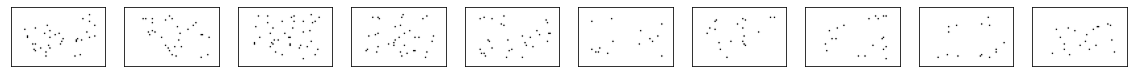

In [ ]:
n = 10
plt.figure(figsize=(20, 6))
for i in range(n):
    # Digit
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(data[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

In [ ]:
import keras
from keras import layers
from keras.callbacks import EarlyStopping

Build an autoencoder for compressing images

In [ ]:
input_img = keras.Input(shape=(45, 72, 1))

x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((3, 3), padding='same')(x)
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((3, 3), padding='same')(x)

# At this point the representation is (7, 7, 32)

x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((3, 3))(x)
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((3, 3))(x)
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
encoder = keras.Model(input_img, encoded)
autoencoder = keras.Model(input_img, decoded)

autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

Show the architecture of the autoencoder

In [ ]:
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 45, 72, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 45, 72, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 24, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 15, 24, 16)        2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 8, 16)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 8, 16)          2320      
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 15, 24, 16)        0   

In [ ]:
autoencoder.fit(x_train, x_train,
                epochs=200,
                batch_size=32,
                shuffle=True,
                validation_data=(x_test, x_test),
                callbacks=[EarlyStopping(monitor="val_loss", patience=10, verbose=0, mode="auto", restore_best_weights=True)])

Epoch 1/200
138/138 [==============================] - 21s 148ms/step - loss: 0.2085 - val_loss: 0.0076
Epoch 2/200
138/138 [==============================] - 20s 144ms/step - loss: 0.0073 - val_loss: 0.0071
Epoch 3/200
138/138 [==============================] - 20s 144ms/step - loss: 0.0070 - val_loss: 0.0070
Epoch 4/200
138/138 [==============================] - 20s 144ms/step - loss: 0.0070 - val_loss: 0.0069
Epoch 5/200
138/138 [==============================] - 20s 144ms/step - loss: 0.0070 - val_loss: 0.0070
Epoch 6/200
138/138 [==============================] - 20s 144ms/step - loss: 0.0069 - val_loss: 0.0071
Epoch 7/200
138/138 [==============================] - 20s 144ms/step - loss: 0.0069 - val_loss: 0.0069
Epoch 8/200
138/138 [==============================] - 20s 144ms/step - loss: 0.0069 - val_loss: 0.0069
Epoch 9/200
138/138 [==============================] - 20s 144ms/step - loss: 0.0069 - val_loss: 0.0070
Epoch 10/200
138/138 [==============================] - 20s 144m

KeyboardInterrupt: ignored

In [ ]:
autoencoder.save("autoencoder_save", overwrite=True)
encoder.save("encoder_save", overwrite=True)
# decoded.save("decoder_save", overwrite=T)

INFO:tensorflow:Assets written to: autoencoder_save/assets
INFO:tensorflow:Assets written to: encoder_save/assets


In [ ]:
compressed_img = encoder.predict(x_test)
results = autoencoder.predict(x_test)

In [ ]:
from keras.models import load_model
autoencoder_disk = load_model("autoencoder_save")
encoder_disk = load_model("encoder_save")

In [ ]:
compressed_img_disk = encoder_disk.predict(x_test)
results_disk = autoencoder_disk.predict(x_test)

Show images comparing original, reconstructed and compressed images

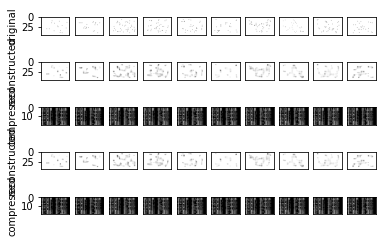

In [ ]:
n = 10
plt.figure()
for i, k in enumerate(np.random.randint(1,len(results)+1,n)):
    ax = plt.subplot(5, n, i + 1)
    plt.imshow(x_test[k].reshape(45, 72))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i==0:
      ax.get_yaxis().set_visible(True)
      ax.set_ylabel('original')

    ax = plt.subplot(5, n, i + 1 + n)
    plt.imshow(results[k].reshape(45, 72))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i==0:
      ax.get_yaxis().set_visible(True)
      ax.set_ylabel('reconstructed')

    ax = plt.subplot(5, n, i + 1 + n * 2)
    plt.imshow(compressed_img[k].reshape(20, 32))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i==0:
      ax.get_yaxis().set_visible(True)
      ax.set_ylabel('compressed')
    
    ax = plt.subplot(5, n, i + 1 + n * 3)
    plt.imshow(results_disk[k].reshape(45, 72))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i==0:
      ax.get_yaxis().set_visible(True)
      ax.set_ylabel('reconstructed')

    ax = plt.subplot(5, n, i + 1 + n * 4)
    plt.imshow(compressed_img_disk[k].reshape(20, 32))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i==0:
      ax.get_yaxis().set_visible(True)
      ax.set_ylabel('compressed')
plt.show()

In [ ]:
import tensorflow as tf
print("original vs reconstructed", np.mean(tf.image.ssim(x_test, results, max_val = np.max(results))))


# print("trained_latent vs load_latent", np.mean(tf.image.ssim(compressed_img_disk, compressed_img, max_val = np.max(compressed_img))))


print("trained_result vs load_result", np.mean(tf.image.ssim(results_disk, results, max_val = np.max(results))))

original vs reconstructed 0.9221696
trained_result vs load_result 1.0


In [ ]:
test_compress = encoder.predict(x_test).reshape(878,20,32)
train_compress = encoder.predict(x_train).reshape(4385,20,32)

In [ ]:
print(test_compress.shape)
print(train_compress.shape)

# Modify humans results to 20 x 32


In [ ]:
def plt_cluster(clusters, image_name):
  fig = plt.figure(figsize=(1,5/8))
  plt.xlim((0,800))
  plt.ylim((0,500))
  plt.axis('off')

  # clusters = subject[trial]['clusters']
  X = []
  Y = []
  for cluster in (clusters):
    for dot in cluster:
      X.append(dot['x'])
      Y.append(dot['y'])
    
  plt.scatter(X,Y, c ='black', s = 1/800)
  plt.show()

  #fig.savefig('/content/drive/MyDrive/base_uuid/'+image_name+'.png')
  plt.close()

In [ ]:
import pandas as pd
path_to_json =clustering_data
json_files = [pos_json for pos_json in os.listdir(path_to_json) if pos_json.endswith('.json')]

data = pd.DataFrame(columns=['base_uuid', 'clusters', 'participant', 'unique_uuid', 'group'])

# we need both the json and an index number so use enumerate()
index = 0
for _, js in enumerate(json_files):
    with open(os.path.join(path_to_json, js)) as json_file:
        json_data = json.load(json_file)
        for sample in json_data:
            if sample["flipped"]:
                # print(sample["clusters"])
                unflipped = []
                for cluster in sample["clusters"]:
                    unflipped.append(list(map(lambda p: {"x": 800 - p["x"], "y": 500 - p["y"]}, cluster)))
                sample["clusters"] = unflipped
            
            
            #plt_cluster(sample["clusters"], sample["base_uuid"])
            # print(sample["base_uuid"])
            # print(sample["clusters"])
            data.loc[index] = np.array((sample["base_uuid"], sample["clusters"], sample["participant_id"], sample['unique_uuid'], sample['group']))
            index += 1



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [ ]:
human_image = '/content/drive/MyDrive/base_uuid/'

In [ ]:
human_dataset = list(filter(lambda x: '.png' in x, os.listdir(clustering_image)))
human_data = np.array([np.array(Image.open(clustering_image + fname).convert('L')) for fname in human_dataset])
print('number of images: ', len(human_data))

number of images:  5264


In [ ]:

x_original = human_data

x_original = x_original.astype('float32') / 255.

x_original =  np.reshape(x_original, (len(x_original), 45,72, 1))


In [ ]:
compressed_img_human = encoder.predict(x_original).reshape(5264,20,32)

results_human = autoencoder.predict(x_original)

In [ ]:
print("original vs reconstructed", np.mean(tf.image.ssim(results_human, x_original, max_val = np.max(results_human))))


In [ ]:
from sklearn.metrics.cluster import fowlkes_mallows_score
import os, json
import pandas as pd
def fm_index_points(a, b):
    # print(a)
    # print(b)
    points = set()
    cluster_a = dict() # point -> cluster number
    cluster_b = dict() 
    for i, cluster in enumerate(a):
        for p in cluster:
            cluster_a[(p["x"], p["y"])] = i
            points.add((p["x"], p["y"]))
    for i, cluster in enumerate(b):
        for p in cluster:
            cluster_b[(p["x"], p["y"])] = i
    
    binary_a = []
    binary_b = []
    for p in points:
        binary_a.append(cluster_a[p])
        if p in cluster_b:
            binary_b.append(cluster_b[p])
        else:
            binary_b.append(-1)

    # print(binary_a)
    # print(binary_b)        
    return fowlkes_mallows_score(binary_a, binary_b)

In [ ]:
import itertools
fm_data = pd.DataFrame(columns=["base_uuid", "fm_score", "group"])
fm_data['fm_score'] = fm_data['fm_score'].astype(float)

uuids = data[["base_uuid"]]
index = 0
for index, uuid in uuids.iterrows():
    uuid = uuid["base_uuid"]
    # print(uuid)
    filtered_data = data.loc[data["base_uuid"] == uuid]
    # print(filtered_data)
    # if len(filtered_data) > 0:
    #     points = np.array(np.concatenate(filtered_data.iloc[0]["clusters"]).flat)
    #     print(points)
    #     hopkins_statistic = hopkins(points)
    # print(filtered_data)
    cc = list(itertools.combinations(set(filtered_data["unique_uuid"]), 2))
    for pair in cc:
        
        cluster1 = list(data.loc[data["unique_uuid"] == pair[0]]["clusters"])[0]
        cluster2 = list(data.loc[data["unique_uuid"] == pair[1]]["clusters"])[0]
        # print(pair[0][0])
        fm_data.loc[index] = np.array((uuid, float(fm_index_points(cluster1, cluster2)), filtered_data.iloc[0]["group"]))
        index += 1
   

    # for sample in data.loc[data['base_uuid'] == uuid].iterrows():
        # print(row)

# avg over pairs of clusterings in base_uuid's samples

# cc = list(itertools.combinations(uuids, 2))
# print(cc)
# pd.DataFrame([data.loc[c,:].sum() for c in cc], index=cc)
fm_data['fm_score'] = pd.to_numeric(fm_data['fm_score'])


fm_data.head()

,base_uuid,fm_score,group
0,2bb1495b-1ef6-4943-bb48-662371f50b30,0.816497,clustered
1,6b397277-e2cf-4165-9f1a-32aeef65ebbc,0.612372,clustered
2,2f452eee-c0bb-437c-bd4e-f35ee9fe9ff6,0.255377,clustered
3,4fbeab87-3c1b-44f6-91c7-47cb4e50c315,0.504878,clustered
4,839dbbc1-445d-4298-95c3-38299943cfb6,0.557086,clustered


In [ ]:
fm_data

In [ ]:
cluster_data = []
disperse_data = []

for i in range(5264):
  if fm_data['group'][i] == 'clustered':
    cluster_data.append(fm_data['base_uuid'][i])
  else:
    disperse_data.append(fm_data['base_uuid'][i])


In [ ]:
print(len(cluster_data))
print(cluster_data)

2632
['2bb1495b-1ef6-4943-bb48-662371f50b30', '6b397277-e2cf-4165-9f1a-32aeef65ebbc', '2f452eee-c0bb-437c-bd4e-f35ee9fe9ff6', '4fbeab87-3c1b-44f6-91c7-47cb4e50c315', '839dbbc1-445d-4298-95c3-38299943cfb6', 'e0b28b0d-8194-475b-98a6-6931d1ff1004', '8ced8977-7d84-444f-9648-a0c4b65e45ce', '37ecaaa0-dbb1-4b98-ad55-ce73229d5866', 'be66f0f4-0431-458a-8aa4-16bc76354c9f', 'fccbc907-4526-43e2-8ded-142b804b471a', '9960e442-6168-430d-b694-abfb5f4339fa', 'e9bc8099-ff66-4017-abd4-33cd8dbcc2d6', '3c4d6c38-877b-41d2-b2b5-d2f74ef0970b', '339f68e4-98bf-4d4a-81c7-06fa958f307e', 'f54baffc-bc26-4c4d-b940-824d08daf230', 'b3697dbc-04ee-4762-a98d-5773cf0c7e84', 'fa83ff0a-5066-4c01-bdf6-909bc3dda074', '51196345-76b0-41da-9c00-5ecb1a87b408', 'fdb55140-d76a-43e5-b66a-8883dc677b94', '0f18f0ad-f23d-4fc9-a761-3920c107550b', '56c594b9-620f-49b9-8302-684c969061da', 'c91f4a09-8df1-4eb3-859a-8dc243343b26', '3808a1ab-27ce-451f-bbd1-525f0e658c07', '98dd5bec-729c-46ed-9714-b1e26e817196', '6da3f9dc-e910-4c46-822b-eebee4448

In [ ]:
import math
def cluster_to_image(clusters):

  

  all_points = []
  for i, cluster in enumerate(clusters):
    for p in cluster:
      print(p)
      # print('x: ', p['x'])
      # print('y: ', p['y'])
      p['x'] = math.floor(p['x'] /25 ) # error
      p['y'] = math.floor(p['y'] /25)
      all_points.append((p['x'], p['y']))
  
  return clusters, all_points

In [ ]:
import pandas as pd
path_to_json = clustering_data
json_files = [pos_json for pos_json in os.listdir(path_to_json) if pos_json.endswith('.json')]

data = pd.DataFrame(columns=['base_uuid', 'clusters', 'participant', 'unique_uuid', 'group'])

disperse_data_list = []
cluster_data_list = []
disperse_point_list = []
cluster_point_list = []

all_data_list = []

# we need both the json and an index number so use enumerate()
index = 0
for _, js in enumerate(json_files):
    with open(os.path.join(path_to_json, js)) as json_file:
        json_data = json.load(json_file)
        for sample in json_data:
            if sample["flipped"]:
                # print(sample["clusters"])
                unflipped = []
                for cluster in sample["clusters"]:
                    unflipped.append(list(map(lambda p: {"x": 800 - p["x"], "y": 500 - p["y"]}, cluster)))
                sample["clusters"] = unflipped
            
            if sample["base_uuid"] in disperse_data:
              cluster_image, point = cluster_to_image(sample["clusters"])
              disperse_data_list.append(cluster_image)
              disperse_point_list.append(point)
            else:
              cluster_image, point = cluster_to_image(sample["clusters"])
              cluster_data_list.append(cluster_image)
              cluster_point_list.append(point)
            
            all_data_list.append(cluster_image)


            
            
            #plt_cluster(sample["clusters"], sample["base_uuid"])
            # print(sample["base_uuid"])
            # print(sample["clusters"])
            data.loc[index] = np.array((sample["base_uuid"], sample["clusters"], sample["participant_id"], sample['unique_uuid'], sample['group']))
            index += 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [ ]:
# print(len(cluster_data_list))
# print(cluster_data_list)

# print(len(disperse_data_list))
# print(disperse_data_list)

print(len(all_data_list))
print(all_data_list)



5264
[[[{'x': 1, 'y': 4}, {'x': 0, 'y': 1}, {'x': 0, 'y': 1}], [{'x': 20, 'y': 7}, {'x': 19, 'y': 4}, {'x': 23, 'y': 4}, {'x': 21, 'y': 4}, {'x': 18, 'y': 5}, {'x': 26, 'y': 7}, {'x': 21, 'y': 7}], [{'x': 22, 'y': 16}, {'x': 20, 'y': 12}], [{'x': 8, 'y': 17}, {'x': 7, 'y': 17}, {'x': 12, 'y': 17}, {'x': 8, 'y': 16}, {'x': 4, 'y': 17}], [{'x': 8, 'y': 4}, {'x': 9, 'y': 8}, {'x': 13, 'y': 11}, {'x': 5, 'y': 5}, {'x': 7, 'y': 9}, {'x': 12, 'y': 9}, {'x': 7, 'y': 5}], [{'x': 15, 'y': 2}]], [[{'x': 15, 'y': 9}, {'x': 16, 'y': 9}], [{'x': 11, 'y': 2}, {'x': 12, 'y': 3}], [{'x': 5, 'y': 11}, {'x': 4, 'y': 11}], [{'x': 26, 'y': 11}], [{'x': 31, 'y': 14}], [{'x': 10, 'y': 13}], [{'x': 5, 'y': 3}]], [[{'x': 19, 'y': 3}, {'x': 18, 'y': 4}, {'x': 19, 'y': 3}], [{'x': 25, 'y': 1}, {'x': 25, 'y': 1}], [{'x': 26, 'y': 5}, {'x': 27, 'y': 7}], [{'x': 29, 'y': 19}, {'x': 30, 'y': 17}], [{'x': 23, 'y': 13}, {'x': 22, 'y': 14}], [{'x': 20, 'y': 16}, {'x': 21, 'y': 17}], [{'x': 10, 'y': 7}, {'x': 8, 'y': 8

# OPTICS

In [ ]:
from sklearn.cluster import OPTICS


In [ ]:
def position_3d(image):
  rows, columns = image.shape
  matrix = np.zeros((rows*columns, 4))
  weight = np.zeros((rows*columns))
  index = 0
  for row in range(rows):
    for column in range(columns):
      matrix[index, 0] = column # x
      matrix[index, 1] = row # y
      matrix[index, 2] = image[row, column]
      weight[index] = image[row, column]
      index += 1
  
  return matrix, weight


In [ ]:
def cluster_to_pos_3d(clustering, matrix):
  # min_label = min(clustering)
  # max_label = max(clustering)
  # clusters = dict()
  # for label in range(min_label, max_label + 1):
  #   cluster[str(label)] =[i for i, e in enumerate(clustering) if e == label]

  for i in range(len(clustering)):
    matrix[i, 3] = clustering[i]
  
  return matrix

In [ ]:
def plot_compress_cluster_3d(matrix):
  color = ['blue', 'red', 'green', 'yellow', 'purple', 'brown']
  min_label = int(min(matrix[:,3]))
  max_label = int(max(matrix[:,3]))
  # print('min: ',min_label)
  # print('max: ',max_label)
  
  # plt.figure()
  # plt.axis('off')
  color_id = 0

  image = np.zeros((20,32))
  id = 0
  for i in range(20):
    for j in range(32):
      image[i, j] = matrix[id,3]
      id += 1



  return image

In [ ]:


def one_sub_one_trial_non_save(subject, filename):
 

  # color = ['blue', 'red', 'green', 'yellow', 'purple', 'brown']
  # col = 0
  for trial in range(len(subject)):
    fig = plt.figure(figsize=(1,5/8))
    plt.xlim((0,800))
    plt.ylim((0,500))
    plt.axis('off')

    clusters = subject[trial]['clusters']
    print(clusters)

    cluster_image, all_points = cluster_to_image(clusters)

  
    X = []
    Y = []


    dot_list = np.zeros((50,3))
    matrix = np.zeros((20,32))
   
    id = 0
    cluster_label = 1
    for cluster in (clusters):
      for dot in cluster:
        X.append(dot['x'])
        Y.append(dot['y'])
       

        matrix[ round(dot['y']/25)-1, round(dot['x']/ 25)-1] = cluster_label

        dot_list[id, 0] = math.floor(dot['y']/25)
        dot_list[id, 1] = math.floor(dot['x']/25)
        dot_list[id, 2] = cluster_label-1
        id += 1
      

      
      cluster_label += 1
    matrix = matrix/len(clusters)
    
    return matrix, dot_list
        
       
    # plt.scatter(X,Y, c ='black', s = 1/800)

    # #fig.savefig('/content/drive/MyDrive/small_cluster_image/'+str(filename)+'_trial_'+str(trial)+'.png')
    # plt.close()
 

[[{'x': 48, 'y': 112}, {'x': 23, 'y': 30}, {'x': 12, 'y': 39}], [{'x': 523, 'y': 187}, {'x': 482, 'y': 122}, {'x': 586, 'y': 122}, {'x': 532, 'y': 105}, {'x': 466, 'y': 138}, {'x': 657, 'y': 179}, {'x': 533, 'y': 194}], [{'x': 550, 'y': 404}, {'x': 519, 'y': 323}], [{'x': 207, 'y': 431}, {'x': 185, 'y': 445}, {'x': 317, 'y': 437}, {'x': 209, 'y': 407}, {'x': 124, 'y': 435}], [{'x': 217, 'y': 124}, {'x': 234, 'y': 214}, {'x': 330, 'y': 294}, {'x': 133, 'y': 138}, {'x': 195, 'y': 237}, {'x': 320, 'y': 244}, {'x': 181, 'y': 142}], [{'x': 377, 'y': 59}]]
[[{'x': 552, 'y': 192}, {'x': 711, 'y': 189}, {'x': 451, 'y': 25}, {'x': 466, 'y': 146}, {'x': 707, 'y': 318}], [{'x': 97, 'y': 374}, {'x': 225, 'y': 112}, {'x': 138, 'y': 337}, {'x': 320, 'y': 135}, {'x': 21, 'y': 256}, {'x': 132, 'y': 160}, {'x': 254, 'y': 308}, {'x': 22, 'y': 455}, {'x': 38, 'y': 414}], [{'x': 438, 'y': 443}]]
[[{'x': 386, 'y': 148}, {'x': 270, 'y': 44}, {'x': 81, 'y': 59}, {'x': 210, 'y': 113}, {'x': 214, 'y': 173}], [

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if __name__ == '__main__':


[[{'x': 484, 'y': 85}, {'x': 465, 'y': 128}], [{'x': 512, 'y': 448}, {'x': 612, 'y': 345}, {'x': 260, 'y': 406}, {'x': 128, 'y': 329}, {'x': 338, 'y': 481}, {'x': 134, 'y': 476}], [{'x': 720, 'y': 13}], [{'x': 165, 'y': 78}]]
[[{'x': 132, 'y': 86}], [{'x': 125, 'y': 292}, {'x': 115, 'y': 282}], [{'x': 255, 'y': 337}], [{'x': 395, 'y': 239}, {'x': 405, 'y': 232}], [{'x': 295, 'y': 62}, {'x': 314, 'y': 76}], [{'x': 657, 'y': 283}], [{'x': 786, 'y': 363}]]
[[{'x': 684, 'y': 243}, {'x': 615, 'y': 296}, {'x': 626, 'y': 42}, {'x': 622, 'y': 187}, {'x': 595, 'y': 169}, {'x': 506, 'y': 207}], [{'x': 382, 'y': 136}, {'x': 391, 'y': 183}], [{'x': 152, 'y': 104}], [{'x': 492, 'y': 431}, {'x': 333, 'y': 367}, {'x': 585, 'y': 485}, {'x': 746, 'y': 447}, {'x': 604, 'y': 407}, {'x': 388, 'y': 419}], [{'x': 121, 'y': 442}, {'x': 132, 'y': 311}, {'x': 67, 'y': 455}, {'x': 228, 'y': 470}, {'x': 178, 'y': 395}]]
[[{'x': 260, 'y': 406}, {'x': 128, 'y': 329}, {'x': 338, 'y': 481}, {'x': 134, 'y': 476}], [{

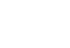

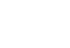

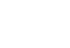

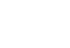

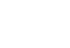

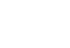

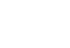

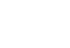

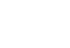

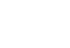

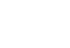

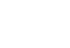

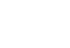

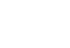

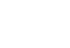

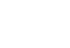

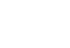

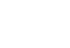

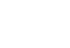

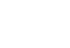

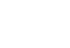

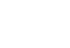

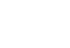

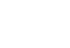

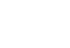

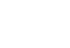

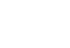

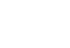

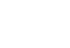

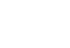

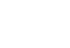

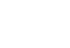

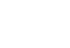

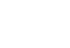

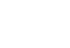

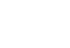

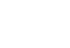

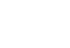

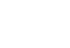

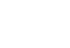

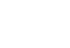

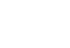

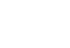

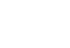

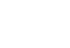

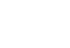

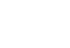

In [ ]:
import os

subject = 0

matrix_list = []
dot_list_list = []
for filename in os.listdir(clustering_data):
    if filename.endswith('.json'):
        with open(os.path.join(clustering_data, filename)) as f:
            subject = json.load(f)
            # print('subject: ', (subject['clusters']))
            
            matrix, dot_list = one_sub_one_trial_non_save(subject, filename[:-5])
            dot_list_list.append(dot_list)
            matrix_list.append(matrix)
print('finish')        

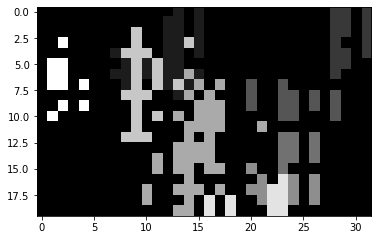

In [ ]:
n = 10 #len(train_compress[i])
from sklearn.preprocessing import normalize
for i in range(n):
   
   
    matrix, weight = position_3d(compressed_img_human[i])
    # print('matrix: ', matrix)
    normed_matrix = normalize(matrix, axis=0)
    # print('normal matrix: ', normed_matrix)
    clustering = OPTICS(min_samples=10).fit(normed_matrix)
    region_matrix = cluster_to_pos_3d(clustering.labels_, normed_matrix)
   
    image = plot_compress_cluster_3d(region_matrix)
    

    plt.imshow(image)
    plt.gray()

    
  

# Fowlkes-Mallows indices

In [ ]:
def compress_img_to_img(compressed_img_human_id, min_sample):
  matrix, weight = position_3d(compressed_img_human_id)
  # print('matrix: ', matrix)
  normed_matrix = normalize(matrix, axis=0)
  # print('normal matrix: ', normed_matrix)

  clustering = OPTICS(min_samples=min_sample).fit(normed_matrix)
  region_matrix = cluster_to_pos_3d(clustering.labels_, normed_matrix)
  
  image = plot_compress_cluster_3d(region_matrix)
  return image

In [ ]:
 
from sklearn.preprocessing import normalize
def image_to_cluster(image, all_points):


   
   


  classes = []
  image_points = dict()
  for point in all_points:
  
    (x, y) = point

    if image[y, x] in classes:
      image_points[str(image[y,x])].append({'x':x, 'y':y})
    
    else:
      classes.append(image[y, x])
      image_points[str(image[y,x])] = []


      image_points[str(image[y,x])].append({'x':x, 'y':y})
    

  dbscan_cluster = []
  for key in image_points.keys():
    dbscan_cluster.append(image_points[key])

  return dbscan_cluster





In [ ]:
from sklearn.metrics.cluster import fowlkes_mallows_score
import os, json
import pandas as pd
def fm_index_points(a, b):
    # print(a)
    # print(b)
    points = set()
    cluster_a = dict() # point -> cluster number
    cluster_b = dict() 
    for i, cluster in enumerate(a):
        for p in cluster:
            cluster_a[(p["x"], p["y"])] = i
            points.add((p["x"], p["y"]))
    for i, cluster in enumerate(b):
        for p in cluster:
            cluster_b[(p["x"], p["y"])] = i
    
    binary_a = []
    binary_b = []
    for p in points:
        binary_a.append(cluster_a[p])
        if p in cluster_b:
            binary_b.append(cluster_b[p])
        else:
            binary_b.append(-1)

    # print(binary_a)
    # print(binary_b)        
    return fowlkes_mallows_score(binary_a, binary_b)

In [ ]:
import pandas as pd
path_to_json =clustering_data
json_files = [pos_json for pos_json in os.listdir(path_to_json) if pos_json.endswith('.json')]

data = pd.DataFrame(columns=['base_uuid', 'clusters', 'participant', 'unique_uuid', 'group'])



# we need both the json and an index number so use enumerate()
index = 0
disperse_id = 0
cluster_id = 0

cluster_fm = []
disperse_fm = []

all_fm = []
import time
start_time = time.time()
min_sample = 18

all_base_uuid = []
for _, js in enumerate(json_files):
    with open(os.path.join(path_to_json, js)) as json_file:
        json_data = json.load(json_file)
        for sample in json_data:
            if sample["flipped"]:
                # print(sample["clusters"])
                unflipped = []
                for cluster in sample["clusters"]:
                    unflipped.append(list(map(lambda p: {"x": 800 - p["x"], "y": 500 - p["y"]}, cluster)))
                sample["clusters"] = unflipped
            
            if sample["base_uuid"] in disperse_data:

              image = compress_img_to_img(compressed_img_human[index], min_sample)
              # _, all_points = cluster_to_image(disperse_data_list[cluster_id])
              dbsacan_cluster = image_to_cluster(image, disperse_point_list[disperse_id])
              fm = fm_index_points(disperse_data_list[disperse_id], dbscan_cluster)
              disperse_fm.append(fm)
              disperse_id += 1
              if fm == 0 or fm == 1.0:

                print(index, fm, "disperse")


              # fm = 0 
              # for min_sample in range(2, 13):
              #   image = compress_img_to_img(compressed_img_human[index], min_sample)
              #   # _, all_points = cluster_to_image(disperse_data_list[cluster_id])
              #   dbsacan_cluster = image_to_cluster(image, disperse_point_list[disperse_id])
              #   fm_temp = fm_index_points(disperse_data_list[disperse_id], dbscan_cluster)
              # # print('human: ',disperse_data_list[cluster_id])
               
              #   if fm_temp > fm:
              #     fm = fm_temp
              # disperse_fm.append(fm)
             
              
              # disperse_id += 1
            else:
              image = compress_img_to_img(compressed_img_human[index], min_sample)
              # _, all_points = cluster_to_image(cluster_data_list[cluster_id])
              
              dbscan_cluster = image_to_cluster(image, cluster_point_list[cluster_id])
              # print('human: ',cluster_data_list[cluster_id])
              # print('dbscan: ', dbscan_cluster)
              fm = fm_index_points(cluster_data_list[cluster_id], dbscan_cluster)
              cluster_fm.append(fm)
              cluster_id += 1

              if fm == 0 or fm == 1.0:

                print(index, fm, "cluster")

              # print(compressed_img_human[index])
              # fm = 0
              # for min_sample in range(7, 20):
              #   image = compress_img_to_img(compressed_img_human[index], min_sample)
              
              #   # _, all_points = cluster_to_image(cluster_data_list[cluster_id])
              #   dbscan_cluster = image_to_cluster(image, cluster_point_list[cluster_id])
              #   # print('human: ',cluster_data_list[cluster_id])
              #   # print('dbscan: ', dbscan_cluster)
              #   fm_temp = fm_index_points(cluster_data_list[cluster_id], dbscan_cluster)

              #   print(min_sample, fm)

              #   if fm_temp > fm:
              #     fm = fm_temp
              # cluster_fm.append(fm)
              # cluster_id += 1
            
            all_fm.append(fm)
            all_base_uuid.append(sample["base_uuid"])
            # print(sample["base_uuid"])
            
  
            index += 1
           

            if index % 500 == 0:
              print(index, time.time() - start_time)

500 237.73913264274597
1000 474.51732754707336
1014 0.0 disperse
1044 1.0 cluster
1052 1.0 cluster
1053 1.0 cluster
1054 1.0 cluster
1058 1.0 cluster
1070 1.0 cluster
1072 1.0 cluster
1083 1.0 disperse
1093 1.0 disperse
1097 1.0 disperse
1099 1.0 disperse
1103 1.0 disperse
1116 1.0 disperse
1118 1.0 disperse
1500 711.5508480072021
1919 1.0 disperse
2000 948.3275866508484
2500 1184.3344895839691
3000 1421.3656077384949
3259 1.0 disperse
3500 1658.552734375
3559 1.0 cluster
4000 1895.2535104751587
4072 1.0 cluster
4074 1.0 cluster
4076 1.0 disperse
4079 1.0 cluster
4080 1.0 disperse
4084 1.0 cluster
4089 1.0 cluster
4090 1.0 cluster
4091 1.0 cluster
4093 1.0 cluster
4094 1.0 cluster
4095 1.0 cluster
4096 1.0 cluster
4098 1.0 disperse
4099 1.0 cluster
4100 1.0 disperse
4102 1.0 cluster
4103 1.0 disperse
4106 1.0 disperse
4107 1.0 disperse
4110 1.0 cluster
4111 1.0 cluster
4113 1.0 cluster
4116 1.0 cluster
4118 1.0 cluster
4120 1.0 cluster
4122 1.0 disperse
4124 1.0 cluster
4125 1.0 disper

In [ ]:
import pandas as pd
dictc = {'all_base_uuid': all_base_uuid, 'all_fm': all_fm}
df = pd.DataFrame(dictc)
df.to_csv('/content/drive/MyDrive/vijay.csv')

print(all_fm)
print(len(all_base_uuid))

[0.4423258684646914, 0.2581988897471611, 0.24349237677883698, 0.3518657752744984, 0.4472135954999579, 0.47016234598162726, 0.4714045207910317, 0.435285750066007, 0.6831300510639732, 0.3779644730092272, 0.47016234598162726, 0.4006683379765067, 0.4216370213557839, 0.47809144373375745, 0.40237390808147827, 0.502518907629606, 0.33267391956523024, 0.35355339059327373, 0.34698416383208147, 0.5027397465361703, 0.4230217115244236, 0.6324555320336759, 0.3899317679104012, 0.38388594797495723, 0.52717704118668, 0.3086066999241838, 0.5163977794943222, 0.34792618696922967, 0.27804842090856746, 0.23860678611591665, 0.1789066118330336, 0.26695386832951484, 0.3347931635358085, 0.19990978330185152, 0.2749064372795948, 0.37206604510436886, 0.21967735023606552, 0.3228567069180544, 0.24912606384792968, 0.34117754381277265, 0.3210289415620512, 0.29488391230979427, 0.21440225485260195, 0.22459720919038548, 0.30323921743156135, 0.2717914161090705, 0.3131121455425747, 0.5003554924018236, 0.2676090120555235, 0

2632
[0.4423258684646914, 0.2581988897471611, 0.24349237677883698, 0.3518657752744984, 0.4472135954999579, 0.47016234598162726, 0.4714045207910317, 0.47016234598162726, 0.4006683379765067, 0.4216370213557839, 0.47809144373375745, 0.33267391956523024, 0.34698416383208147, 0.3899317679104012, 0.52717704118668, 0.5163977794943222, 0.27804842090856746, 0.26695386832951484, 0.2749064372795948, 0.21967735023606552, 0.34117754381277265, 0.21440225485260195, 0.30323921743156135, 0.3131121455425747, 0.5003554924018236, 0.47766514722122566, 0.4525885718428285, 0.4207273395595698, 0.5163977794943222, 0.5163977794943222, 0.2850944531840176, 0.5372059663940645, 0.44982345106024185, 0.4704492928169951, 0.4760952285695233, 0.42538497969766276, 0.48952153824477423, 0.4714045207910317, 0.4216370213557839, 0.33267391956523024, 0.34772170491397114, 0.2606697488177674, 0.28538802684370673, 0.40744067683325375, 0.23190841426097938, 0.31440511241492825, 0.4216370213557839, 0.47809144373375745, 0.41247895569

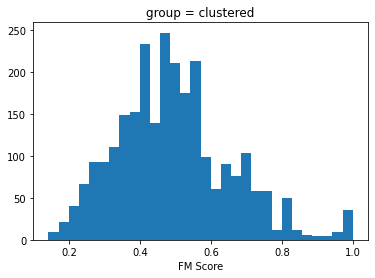

0.4942029933047903
0.16004923461835432


In [ ]:
print(len(cluster_fm))
print(cluster_fm)

plt.hist(cluster_fm, bins=30)
plt.title('group = clustered')
plt.xlabel('FM Score')
plt.show()
print(np.mean(cluster_fm))
print(np.std(cluster_fm))

2632
[0.435285750066007, 0.6831300510639732, 0.3779644730092272, 0.40237390808147827, 0.502518907629606, 0.35355339059327373, 0.5027397465361703, 0.4230217115244236, 0.6324555320336759, 0.38388594797495723, 0.3086066999241838, 0.34792618696922967, 0.23860678611591665, 0.1789066118330336, 0.3347931635358085, 0.19990978330185152, 0.37206604510436886, 0.3228567069180544, 0.24912606384792968, 0.3210289415620512, 0.29488391230979427, 0.22459720919038548, 0.2717914161090705, 0.2676090120555235, 0.34000462769372247, 0.3743841071441071, 0.3765104989580902, 0.4350199123879871, 0.403909551355136, 0.35473606645348177, 0.49204193231664184, 0.3640962810361395, 0.4216370213557839, 0.25787777525350447, 0.5433581647846062, 0.29742484506432626, 0.40951417967396103, 0.29069386642412703, 0.3909645263570152, 0.30550504633038933, 0.3621987284918343, 0.2716319780500123, 0.4976133515281193, 0.3185229510553675, 0.4065595622717274, 0.3414017048491719, 0.3814713902868446, 0.3086066999241838, 0.5962847939999439,

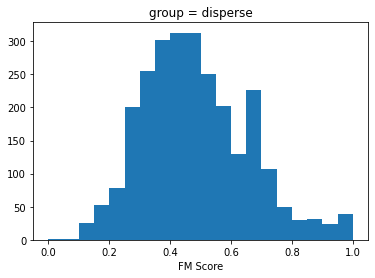

0.4844225812986947
0.17424031928270223


In [ ]:
print(len(disperse_fm))
print(disperse_fm)
plt.hist(disperse_fm, bins=20)
plt.title('group = disperse')
plt.xlabel('FM Score')
plt.show()
print(np.mean(disperse_fm))
print(np.std(disperse_fm))

2632
[0.435285750066007, 0.6831300510639732, 0.3779644730092272, 0.40237390808147827, 0.502518907629606, 0.35355339059327373, 0.5027397465361703, 0.4230217115244236, 0.6324555320336759, 0.38388594797495723, 0.3086066999241838, 0.34792618696922967, 0.23860678611591665, 0.1789066118330336, 0.3347931635358085, 0.19990978330185152, 0.37206604510436886, 0.3228567069180544, 0.24912606384792968, 0.3210289415620512, 0.29488391230979427, 0.22459720919038548, 0.2717914161090705, 0.2676090120555235, 0.34000462769372247, 0.3743841071441071, 0.3765104989580902, 0.4350199123879871, 0.403909551355136, 0.35473606645348177, 0.49204193231664184, 0.3640962810361395, 0.4216370213557839, 0.25787777525350447, 0.5433581647846062, 0.29742484506432626, 0.40951417967396103, 0.29069386642412703, 0.3909645263570152, 0.30550504633038933, 0.3621987284918343, 0.2716319780500123, 0.4976133515281193, 0.3185229510553675, 0.4065595622717274, 0.3414017048491719, 0.3814713902868446, 0.3086066999241838, 0.5962847939999439,

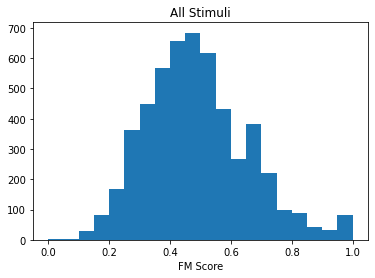

In [ ]:
print(len(disperse_fm))
print(disperse_fm)
plt.hist(disperse_fm+cluster_fm, bins=20)
plt.title('All Stimuli')
plt.xlabel('FM Score')
plt.show()

normal matrix:  [[0.         0.         0.02664139 0.        ]
 [0.00219096 0.         0.0272655  0.        ]
 [0.00438192 0.         0.07626909 0.        ]
 ...
 [0.06353785 0.06758186 0.03702544 0.        ]
 [0.06572881 0.06758186 0.03916831 0.        ]
 [0.06791977 0.06758186 0.00291066 0.        ]]
normal matrix:  [[0.         0.         0.02571418 0.        ]
 [0.00219096 0.         0.02631658 0.        ]
 [0.00438192 0.         0.07361467 0.        ]
 ...
 [0.06353785 0.06758186 0.03573683 0.        ]
 [0.06572881 0.06758186 0.03780513 0.        ]
 [0.06791977 0.06758186 0.02502171 0.        ]]
normal matrix:  [[0.         0.         0.02623091 0.        ]
 [0.00219096 0.         0.0268454  0.        ]
 [0.00438192 0.         0.07509395 0.        ]
 ...
 [0.06353785 0.06758186 0.03645496 0.        ]
 [0.06572881 0.06758186 0.03856481 0.        ]
 [0.06791977 0.06758186 0.00286581 0.        ]]
normal matrix:  [[0.         0.         0.02552049 0.        ]
 [0.00219096 0.         0

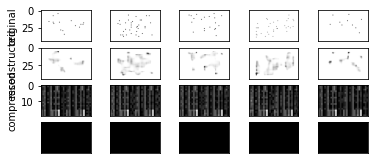

In [ ]:
n = 10 #len(train_compress[i])
from sklearn.preprocessing import normalize

special_case = [1014, 1083, 4138, 977, 4124]
n = len(special_case)
for i, k in enumerate(special_case):
  ax = plt.subplot(6, n, i + 1) # 6: original image, compressed image,dbscan_image, human_cluster, human_image, reconstructed_image
  plt.imshow(x_original[k].reshape(45, 72))
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  if i==0:
    ax.get_yaxis().set_visible(True)
    ax.set_ylabel('original')
  
  ax = plt.subplot(6, n, i + 1 + n) # 6: original image, compressed image,dbscan_image, human_cluster, human_image, reconstructed_image
  plt.imshow(results_human[k].reshape(45, 72))
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  if i==0:
    ax.get_yaxis().set_visible(True)
    ax.set_ylabel('reconstructed')
  
  ax = plt.subplot(6, n, i + 1 + n*2) # 6: original image, compressed image,dbscan_image, human_cluster, human_image, reconstructed_image
  plt.imshow(compressed_img_human[k])
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  if i==0:
    ax.get_yaxis().set_visible(True)
    ax.set_ylabel('compressed')
  
  ax = plt.subplot(6, n, i + 1 + n*3) # 6: original image, compressed image,dbscan_image, human_cluster, human_image, reconstructed_image

  matrix, weight = position_3d(compressed_img_human[k])
  # print('matrix: ', matrix)
  normed_matrix = normalize(matrix, axis=0)
  print('normal matrix: ', normed_matrix)
  clustering = OPTICS(min_samples=18).fit(normed_matrix)
  region_matrix = cluster_to_pos_3d(clustering.labels_, normed_matrix)
  #print(region_matrix)
  image = np.zeros((20,32))
  id = 0
  for i in range(20):
    for j in range(32):
      image[i, j] = region_matrix[id,3]
      id += 1
  #print(image)
  plt.imshow(image)
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  if i==0:
    ax.get_yaxis().set_visible(True)
    ax.set_ylabel('DBscan clusters')
  
  # ax = plt.subplot(6, n, i + 1 + n*3) # 6: original image, compressed image,dbscan_image, human_cluster, human_image, reconstructed_image




id:  [[{'x': 21, 'y': 6}], [{'x': 21, 'y': 6}, {'x': 9, 'y': 17}, {'x': 29, 'y': 10}, {'x': 0, 'y': 16}, {'x': 25, 'y': 9}, {'x': 26, 'y': 8}, {'x': 9, 'y': 8}, {'x': 3, 'y': 3}, {'x': 30, 'y': 15}, {'x': 2, 'y': 2}, {'x': 0, 'y': 4}, {'x': 7, 'y': 2}, {'x': 21, 'y': 12}, {'x': 31, 'y': 1}, {'x': 3, 'y': 4}]]
X:  [21]
Y:  [6]
col:  0
X:  [21, 9, 29, 0, 25, 26, 9, 3, 30, 2, 0, 7, 21, 31, 3]
Y:  [6, 17, 10, 16, 9, 8, 8, 3, 15, 2, 4, 2, 12, 1, 4]
col:  1


<Figure size 432x288 with 0 Axes>

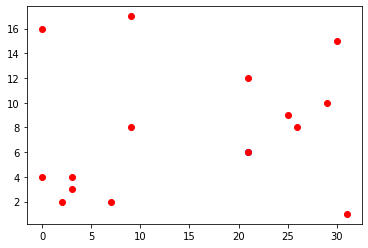

In [ ]:
  color = ['blue', 'red', 'green', 'yellow', 'purple', 'brown', 'olive', 'pink', 'cyan', 'cornsilk', 'magenta', 'darkred']
  # for i, k in enumerate(all_data_list[:5]):
  #   ax = plt.subplot(1, 5, i + 1)
  #   col = 0
  #   clusters = all_data_list[i]
  #   #plt.axis('off')
  #   plt.xlim((0,32))
  #   plt.ylim((0,20))

  #   X = []
  #   Y = []
  #   for cluster in (clusters):
      
  #     for dot in cluster:
     
  #       X.append(dot['x'])
  #       Y.append(dot['y'])
        
  #   print('X: ',(X))
  #   print('Y: ',(Y))
  
      
  #   plt.scatter(X,Y)#, s = 1/800)
    

  #   ax.get_xaxis().set_visible(False)
  #   ax.get_yaxis().set_visible(False)
  #   plt.show()


  
  special_case =[1083]# [1014, 1083, 4138, 977, 4124]
  # print(all_data_list[5000])
  # for trial in range(len(subject)):
  # fig = plt.figure(figsize=(1,5/8))
  plt.figure()
  # plt.xlim((0,800))
  # plt.ylim((0,500))
 
  for id in special_case:
    col = 0
    clusters = all_data_list[id]
    print('id: ', all_data_list[id])
    plt.figure()
    # plt.axis('off')

  
    for cluster in (clusters):
      X = []
      Y = []
      for dot in cluster:
      
        X.append(dot['x'])
        Y.append(dot['y'])
      print('X: ',X)
      print('Y: ',Y)
      
        
      plt.scatter(X,Y, c= color[col])#, s = 1/800)
      print('col: ', col)
      col += 1
    plt.show()

In [ ]:
# cluster_data_list

In [ ]:
print(all_d)